In [0]:
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

In [0]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

In [0]:
model = ResNet50(include_top=True, weights='imagenet')

In [0]:
input_shape=model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [0]:
datagen_train = ImageDataGenerator(
      rescale=1./128)

In [0]:
datagen_test = ImageDataGenerator(rescale=1./128)

In [0]:
epochs=2
batch_size = 20
steps_per_epoch_train=451//20
steps_per_epoch_val=152//20


In [0]:

generator_train = datagen_train.flow_from_directory(directory='./colabData/Colab Notebooks/aml_origin_resum/train1',
                               
                                                    target_size=(224,224),
                                                    batch_size=20,
                                                    class_mode='categorical',shuffle=False)

Found 451 images belonging to 3 classes.


In [0]:

generator_test = datagen_test.flow_from_directory(directory='./colabData/Colab Notebooks/aml_origin_resum/valid1',
                                                  target_size=(224,224),
                                                  batch_size=20,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 152 images belonging to 3 classes.


In [0]:
steps_test = generator_test.n / batch_size
steps_test

7.6

In [0]:
from sklearn.utils.class_weight import compute_class_weight

In [0]:
cls_train = generator_train.classes


In [0]:
cls_test = generator_test.classes

In [0]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(cls_train), y=cls_train)

In [0]:
class_weight

array([0.68960245, 2.59195402, 0.85904762])

In [0]:
transfer_layer = model.get_layer('avg_pool')

In [0]:
transfer_layer.output

<tf.Tensor 'avg_pool/AvgPool:0' shape=(?, 1, 1, 2048) dtype=float32>

In [0]:
conv_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [0]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [0]:
new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dense(1000, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(3, activation='softmax'))

In [0]:

loss='categorical_crossentropy'
metrics=['categorical_accuracy']

In [0]:
def print_layer_trainable():
  for layer in conv_model.layers:
    print("{0}: {1}".format(layer.trainable, layer.name))

In [0]:
for layer in conv_model.layers:
  layer.trainable = False

In [0]:
loss='categorical_crossentropy'
metrics=['categorical_accuracy']


In [0]:
len(conv_model.layers)

175

In [0]:
for layer in conv_model.layers[:]:
 
  layer.trainable=False

In [0]:
print_layer_trainable()

In [0]:
optimizer_fine = Adam(lr=1e-5)
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

In [0]:
earlystopping = EarlyStopping(monitor='val_loss', patience=20)

In [0]:
history1 = new_model.fit_generator(generator=generator_train,
                                  epochs=200,
                                  steps_per_epoch=steps_per_epoch_train,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_per_epoch_val,
                                  callbacks=[earlystopping])


In [0]:
optimizer_fine = Adam(lr=1e-6)
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)
history1 = new_model.fit_generator(generator=generator_train,
                                  epochs=300,
                                  steps_per_epoch=steps_per_epoch_train,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_per_epoch_val,
                                  callbacks=[earlystopping])

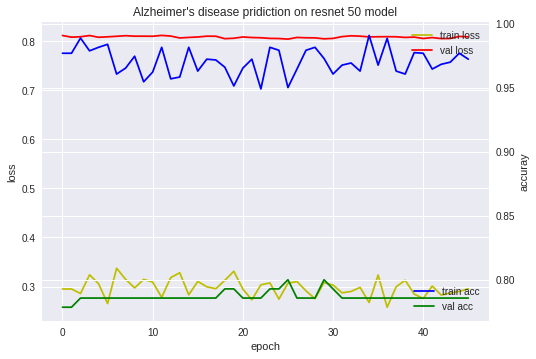

In [0]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history1.history['loss'], 'y', label='train loss')
loss_ax.plot(history1.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history1.history['categorical_accuracy'], 'b', label='train acc')
acc_ax.plot(history1.history['val_categorical_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper right')
acc_ax.legend(loc='lower right')
plt.title("Alzheimer's disease pridiction on resnet 50 model")

plt.show()

In [0]:
model.save('./colabData/Colab Notebooks/model/resnet50_aml_2layernoaug.h5')

In [0]:
class_name = generator_train.class_indices.keys()

In [0]:
train_dir = './colabData/Colab Notebooks/aml_origin_resum/train1'
test_dir = './colabData/Colab Notebooks/aml_origin_resum/valid1'


In [0]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [0]:
len(generator_train.filenames)
len(generator_test.filenames)

152

In [0]:

image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [0]:

cls_train = generator_train.classes
cls_test = generator_test.classes

In [0]:
class_names = list(generator_train.class_indices.keys())
class_names

['1gr', '2gr', '3gr']

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.
    re = classification_report(y_true=cls_test,
                               y_pred=cls_pred)
    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    print(re)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name

In [0]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [0]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [0]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

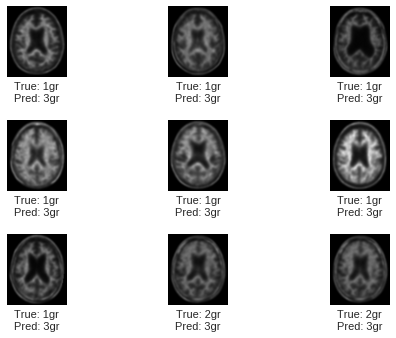

Confusion matrix:
[[66  0  7]
 [ 8  0 12]
 [ 1  2 56]]
             precision    recall  f1-score   support

          0       0.88      0.90      0.89        73
          1       0.00      0.00      0.00        20
          2       0.75      0.95      0.84        59

avg / total       0.71      0.80      0.75       152

(0) 1gr
(1) 2gr
(2) 3gr


In [0]:
example_errors()